# Лабораторная работа № 7
## Автоассоциативные сети с узким горлом

`Цель работы:` исследование свойств автоассоциативных сетей с узким горлом, алгоритмов обучения, а также применение сетей для выполнения линейного и нелинейного анализа главных компонент набора данных.

|Студент| Мариничев И.А.|
|-|-|
|**Группа**| **М8О-408Б-19**|
|**Вариант**| **2**|

Импортируем всё необходимое

In [1]:
import pickle
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

Зададим набор данных для обучения

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding = 'latin1')
    return dict

In [3]:
def get_train_data(path, filter):
    datadict = unpickle(path)

    inputs = datadict['data']
    labels = datadict['labels']

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    print(f"Extracting {classes[filter]} images")
    
    data = list()
    for image, label in zip(inputs, labels):
        if label == filter:
            image = np.asarray(image, np.float32)
            image = image.flatten()
            image = (image - 127.5) / 127.5
            data += [(image, image)]
    return data

In [4]:
core_data = None

In [5]:
width, height = 32, 32
dim_1 = width * height * 3
dim_2, dim_3 = int(dim_1 * 2.0), int(dim_1 / 32.0)

In [6]:
batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

train_data = list()
train_data += get_train_data(path= 'data/cifar-10-batches-py/data_batch_1', filter=(12 % 10))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Extracting bird images


Автоэнкодер представляет из себя две нейронные сети: кодирующую и декодирующую. 

На вход подаются данные, которые кодирующая нейронная сеть (энкодер) преобразует в скрытое пространство меньшей размерности, после чего декодирующая нейронная сеть (декодер) пытается восстановить их из скрытого пространства в пространство размерности входных данных

In [7]:
encoder = nn.Sequential(
    nn.Linear(in_features=dim_1, out_features=dim_2),
    nn.Linear(in_features=dim_2, out_features=dim_3),
    nn.Tanh()
)

decoder = nn.Sequential(
    nn.Linear(in_features=dim_3, out_features=dim_2),
    nn.Linear(in_features=dim_2, out_features=dim_1),
    nn.Tanh()
)

In [8]:
loss_function = nn.MSELoss()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-5)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-5)

Определим функцию обучения на батчах

In [9]:
def fit(model, train_loader, criterion, optimizer, epochs):
    losses = []

    running_loss = 0.0
    processed_data = 0

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            for inputs, labels in train_loader:
                optimizer[0].zero_grad()
                optimizer[1].zero_grad()
                
                encoder_outp = model[0](inputs)
                decoder_outp = model[1](encoder_outp)

                loss = criterion(decoder_outp, labels)

                loss.backward()
                optimizer[0].step()
                optimizer[1].step()

                running_loss += loss.item() * inputs.size(0)
                processed_data += inputs.size(0)

            train_loss = running_loss / processed_data
            losses.append(train_loss)
            pbar_outer.update()
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

Обучим модель

In [ ]:
losses = fit([encoder, decoder], train_loader, loss_function, [encoder_optimizer, decoder_optimizer], 50)

Посмотрим на график функции потерь, вычисляющей `MSE` между исходными и полученными данными

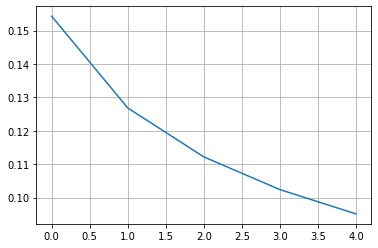

In [11]:
%matplotlib inline
plt.plot(losses)
plt.grid(True, which='both')
plt.show()

И посмотрим на наши результаты

In [12]:
def imshow(img, width=32, height=32):
    img =  (img + 1) / 2     
    img = np.reshape(img, (3, height, width))
    img = np.transpose(img, (1, 2, 0))
    return img

In [13]:
def on_slider_update(axes, decoder, feature, val):
    global core_data
    core_data[feature] = val
    image = decoder(torch.from_numpy(core_data)).detach().numpy()
    image = imshow(image)
    axes.set_array(image)

In [14]:
def on_button_click(axes_gt, axes_out, axes_mod, encoder, decoder, data):
    global core_data
    image = data[np.random.randint(0, len(data))][0]
    enc_out = encoder(torch.from_numpy(image)).detach().numpy()
    dec_out = decoder(torch.from_numpy(enc_out)).detach().numpy()
    core_data = np.copy(enc_out)
    axes_gt.set_array(imshow(image))
    axes_out.set_array(imshow(dec_out))
    axes_mod.set_array(imshow(dec_out)) 
    plt.draw()

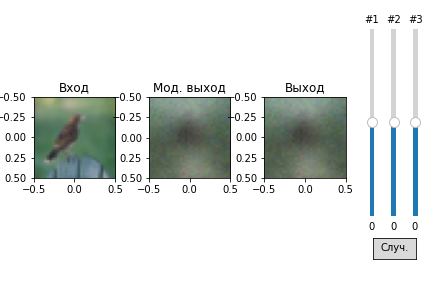

In [15]:
%matplotlib widget
fig, axes = plt.subplots(1, 3)
fig.set_label("Результаты")
fig.tight_layout()

axes[0].set_title("Вход")
axes[0].set_aspect(1)
ax_gt = axes[0].imshow([[0]])

axes[1].set_title("Мод. выход")
axes[1].set_aspect(1)
ax_mod = axes[1].imshow([[0]])

axes[2].set_title("Выход")
axes[2].set_aspect(1)
ax_out = axes[2].imshow([[0]])

features = np.random.randint(low = 0 , high = dim_3, size= 3)

axs_1 = fig.add_axes([0.85, 0.25, 0.0225, 0.65])
slid_1 = Slider(ax= axs_1, label='#1', valinit=0, valmin=-1.0, valmax=1.0, orientation='vertical')
slid_1.on_changed(lambda val: on_slider_update(ax_mod, decoder, features[0] ,val))

axs_2 = fig.add_axes([0.9, 0.25, 0.0225, 0.65])
slid_2 = Slider(ax= axs_2, label='#2', valinit=0, valmin=-1.0, valmax=1.0, orientation='vertical')
slid_2.on_changed(lambda val: on_slider_update(ax_mod, decoder, features[1] ,val))

axs_3 = fig.add_axes([0.95, 0.25, 0.0225, 0.65])
slid_3 = Slider(ax= axs_3, label='#3', valinit=0, valmin=-1.0, valmax=1.0, orientation='vertical')
slid_3.on_changed(lambda val: on_slider_update(ax_mod, decoder, features[2] ,val))

axs_4 = fig.add_axes([0.8625, 0.1, 0.1, 0.075])
btn= Button(ax=axs_4, label="Случ.")
btn.on_clicked(lambda event: on_button_click(ax_gt, ax_out, ax_mod,encoder, decoder,train_data))
on_button_click(ax_gt, ax_out, ax_mod,encoder, decoder,train_data)

plt.subplots_adjust(right=0.8)

plt.show()

`Выводы:` в ходе данной работы была построена автоассоциативная сеть, которая была использована для выполнения линейного и нелинейного
анализа главных компонент набора данных. После `50` эпох обучения были получены верные результаты